## EA MAP ...

``

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sklearn
from sklearn.linear_model import LinearRegression


In [2]:
# parameters

s0 = 100
r = 0.02
sigma = 0.25
range_k = np.arange(80, 120)
nb_sample = 10000
T = 2

fixed_K = 100
Z = np.random.randn(nb_sample)

In [13]:

# Function for computing the payofff
def f(Z , K , s0 = s0 , r = r , sigma = sigma, T = T):
    
    S = s0*np.exp(sigma*np.sqrt(T)*Z - 0.5*sigma**2 * T + r*T) 
    return np.maximum(S-K,0)


def call(K, S0 =s0, T = T, r = r, sigma = sigma):
    """
    This function returns the Black-scholes price of the call
    """
    
    K_disc = K*np.exp(-r*T)
    v = sigma**2 * T
    d1 = np.log(S0/K_disc)/np.sqrt(v) - 0.5*np.sqrt(v)
    d2 = np.log(S0/K_disc)/np.sqrt(v) + 0.5*np.sqrt(v)
    
    price = S0* sps.norm.cdf(d2) - K_disc*sps.norm.cdf(d1)
    
    return price

In [27]:
# defining our model
def NN_model(Z, K, s0 = s0 , r = r , sigma = sigma, T = T):
    model = keras.Sequential()
    model.add( layers.Dense(nb_sample // 2, input_dim = 1, activation = 'relu') )
    model.add( layers.Dense(1))

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Fitting the model
    X_train, Y_train =Z, f(Z, K, s0 , r , sigma, T)
    model.fit(X_train, Y_train)

    # Getting the weights:
    W1, b1 = model.layers[0].get_weights()
    W2, b2  = model.layers[1].get_weights()

    # 
    mu = b1
    sig = W1[0]
    sign_sig = sig > 0
    esp1 = np.abs(sig)*np.exp(-0.5*mu**2/(sig**2))/np.sqrt(2*np.pi) + mu*(sign_sig + (1-2*sign_sig) * sps.norm.cdf(-mu/sig))
    esp2 = np.dot(W2[:,0],esp1) +  b2[0]

    return (W1,b1),(W2,b2),esp2

## Parameters and means 
(W1,b1),(W2,b2), expected_value = NN_model(Z,fixed_K, s0 , r , sigma, T)


313/313 [==============================] - 1s 2ms/step - loss: 754.9083


In [28]:
1-2*(W1[0] > 0)

array([ 1, -1,  1, ...,  1,  1,  1])

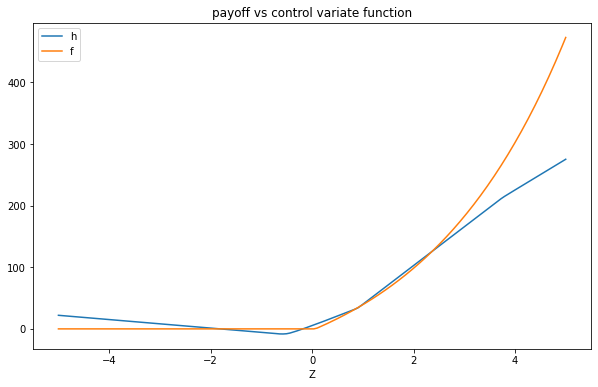

In [29]:
# Control variate function Using the expectation formulae in the paper:
def NN_h(Z, K, W1 = W1 , b1 = b1 , W2 = W2, b2 = b2):
    value = (np.maximum(W1*Z+b1,0) @ W2 + b2 )[0]
    return value 

## Plotting f vs NN_h for fixed_k
plt.figure(figsize = (10,6))
z = np.linspace(-5,5,150)
plt.plot(z,[NN_h(x,fixed_K) for x in z], label = ("h"))
plt.plot(z, f(z, fixed_K),label='f')
plt.xlabel('Z')
plt.title("payoff vs control variate function")
plt.legend()
plt.show()




In [30]:
## Control variate method

###
def NN_f_control(Z , K ,esp, W1 = W1 , b1 = b1 , W2 = W2, b2 = b2):
    h_func = NN_h(Z,K, W1 , b1 , W2, b2)
    return f(Z,K) - h_func + esp

controlled_payoffs = np.zeros((len(range_k),len(Z)))
for i,K in enumerate(range_k):
    (W1,b1),(W2,b2), expected_value = NN_model(Z,K)
    controlled_payoffs[i,:] = np.array([NN_f_control(z,K,expected_value, W1 , b1, W2, b2) for z in Z])[:,0]


std_control = np.std(controlled_payoffs , axis = 1)

control_prices = np.mean(controlled_payoffs, axis =1)*np.exp(-r*T)

IC_control = control_prices + 1.96 / np.sqrt(controlled_payoffs.shape[1]) * np.array([-std_control,std_control])

true_prices = np.array([call(K) for K in range_k])
# error_control = ( np.cumsum( controlled_payoffs[indice_k] ) *np.exp(-r *T)  / np.arange(1,nb_sample+1) )/true_prices[indice_k] - 1

313/313 [==============================] - 1s 2ms/step - loss: 618.3385


No handles with labels found to put in legend.


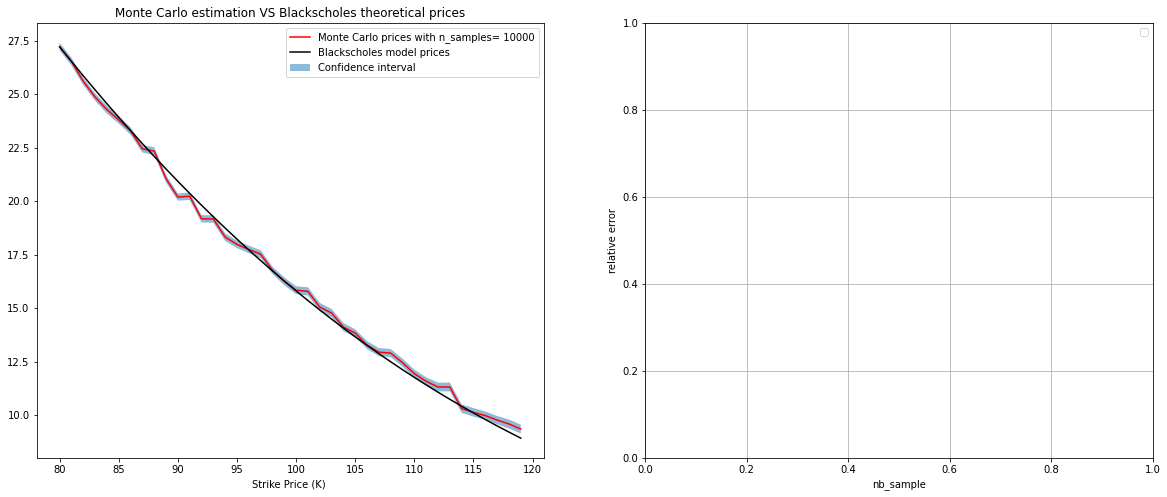

In [31]:
fig,(ax1 , ax2 )  = plt.subplots(1,2, figsize = (20,8) )

ax1.plot(range_k , control_prices , 'r', label = f'Monte Carlo prices with n_samples= {nb_sample}')
ax1.plot(range_k , true_prices,'k', label = 'Blackscholes model prices')
ax1.fill_between(range_k, IC_control[0], IC_control[1], alpha=0.5, label='Confidence interval')
ax1.set_xlabel('Strike Price (K) ')
ax1.set_label('Call prices')
ax1.set_title ( f'Monte Carlo estimation VS Blackscholes theoretical prices' )
ax1.legend(loc = 'best')

#ax2.plot(np.arange(1,nb_sample+1) [:], error_control[:] , label = 'relative error' )
ax2.set_xlabel ('nb_sample')
ax2.set_ylabel ('relative error')
#ax2.set_title (f'relative error between Monte Carlo estimated and Blackscholes theoretical prices for K = {fixed_k} ' )
ax2.legend(loc = 'best')
# ax2.set_ylim((-1,1))
plt.grid()
plt.show()

In [8]:
W1, b1 = model.layers[0].get_weights()
W2, b2  = model.layers[1].get_weights()

NameError: name 'model' is not defined

In [ ]:
W1.shape

In [ ]:
b1.shape

In [ ]:
W2.shape

In [ ]:
b2.shape

In [ ]:
mu/sig

In [ ]:
W1[0].shape

In [ ]:
np.dot(W2,W1+b1).shape

In [ ]:
(W1+b1).shape

In [ ]:
(sig*np.exp(-0.5*mu**2/sig**2)/(2*np.pi) + mu*(1-sps.norm.cdf(-sig/mu))).shape

In [ ]:
b2

In [ ]:
(np.maximum(W1*0.9+b1,0) @ W2 +b2)[0]

In [ ]:
W1.shape

In [ ]:
(10*W1)

In [12]:
controlled_payoffs.shape

(40, 10000)

In [ ]:
W1

In [ ]:
b1

In [ ]:
(W1+b1).shape

In [ ]:
W2.shape

In [ ]:
W1@W2

In [ ]:
np.dot(W1[0],W2[:,0])

In [ ]:
 (np.maximum(W1*0.5+b1,0) @ W2 + b2[0] )

In [ ]:
W2.shape

In [ ]:
sig = np.abs(W1[0])*np.sqrt(T)
esp1 = sig*np.exp(-0.5*mu**2/(sig**2))/(2*np.pi) + mu*(1-sps.norm.cdf(-sig/mu))
esp2 = np.dot(W2[:,0],esp1) +  b2[0]

In [ ]:
esp2